# Before lecture

- Week 12 [presentation](https://colab.research.google.com/drive/1yH_tohlPh4wC1vz0Wt6OzRsdFSJt-qmh?usp=sharing)


# House Keeping

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
import warnings

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import DecisionBoundaryDisplay

import sy_functions as sy

def sy_logit_deviance(y_true, y_pred):
    dev = -2 * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return dev


You may find the function file [here](https://www.dropbox.com/s/zzz9ddc5dfknew9/sy_functions.py?dl=1) and upload it to your google drive.

# Reading

Textbook Page 109-123.

# Binary Outcome

## German Credit Data

We have some data from a German lender.

In [3]:
df_credit = pd.read_csv("https://www.dropbox.com/s/o3r3dteb12fl3k3/credit.csv?dl=1")
df_credit

,Default,checkingstatus1,duration,history,purpose,amount,savings,employ,installment,status,...,residence,property,age,otherplans,housing,cards,job,liable,tele,foreign
0,0,A11,6,A34,A43,1169,A65,A75,4,A93,...,4,A121,67,A143,A152,2,A173,1,A192,A201
1,1,A12,48,A32,A43,5951,A61,A73,2,A92,...,2,A121,22,A143,A152,1,A173,1,A191,A201
2,0,A14,12,A34,A46,2096,A61,A74,2,A93,...,3,A121,49,A143,A152,1,A172,2,A191,A201
3,0,A11,42,A32,A42,7882,A61,A74,2,A93,...,4,A122,45,A143,A153,1,A173,2,A191,A201
4,1,A11,24,A33,A40,4870,A61,A73,3,A93,...,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,A14,12,A32,A42,1736,A61,A74,3,A92,...,4,A121,31,A143,A152,1,A172,1,A191,A201
996,0,A11,30,A32,A41,3857,A61,A73,4,A91,...,4,A122,40,A143,A152,1,A174,1,A192,A201
997,0,A14,12,A32,A43,804,A61,A75,4,A93,...,4,A123,38,A143,A152,1,A173,1,A191,A201
998,1,A11,45,A32,A43,1845,A61,A73,4,A93,...,4,A124,23,A143,A153,1,A173,1,A192,A201


What are those values such as `history="A30"`? [credit.R](https://www.dropbox.com/s/63f546iaz8g6q28/credit.R?dl=0) is the data massage file.
- A data scientist could spend 90% of his time cleaning the data.
- We do not want to be awkwrd when being questioned. So, know your data.

We can factor and label the levels of credit history.

In [4]:
dict_replace = {"A30" : "good",
                "A31" : "good",
                "A32" : "good",
                "A33" : "poor",
                "A34" : "terrible"}
df_credit['history'] = df_credit['history'].replace(dict_replace)
df_credit.history.value_counts()

history
good        619
terrible    293
poor         88
Name: count, dtype: int64

In [5]:
dict_replace = {"A201":"foreign", "A202":"german"}
df_credit['foreign'] = df_credit['foreign'].replace(dict_replace)
df_credit['foreign'].value_counts()

foreign
foreign    963
german      37
Name: count, dtype: int64

In [6]:
df_credit['rent'] = df_credit['housing']=="A151"
df_credit['rent'].value_counts()

rent
False    821
True     179
Name: count, dtype: int64

In [7]:
dict_replace = {"A40" : "newcar",
                "A41" : "usedcar",
                "A42" : "goods/repair",
                "A43" : "goods/repair",
                "A44" : "goods/repair",
                "A45" : "goods/repair",
                "A46" : "edu",
                "A47" : np.nan,
                "A48" : "edu",
                "A49" : "biz",
                "A410" : "biz"}
df_credit['purpose'] = df_credit['purpose'].replace(dict_replace)
df_credit['purpose'].value_counts()

purpose
goods/repair    495
newcar          234
biz             109
usedcar         103
edu              59
Name: count, dtype: int64

In [8]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Default          1000 non-null   int64 
 1   checkingstatus1  1000 non-null   object
 2   duration         1000 non-null   int64 
 3   history          1000 non-null   object
 4   purpose          1000 non-null   object
 5   amount           1000 non-null   int64 
 6   savings          1000 non-null   object
 7   employ           1000 non-null   object
 8   installment      1000 non-null   int64 
 9   status           1000 non-null   object
 10  others           1000 non-null   object
 11  residence        1000 non-null   int64 
 12  property         1000 non-null   object
 13  age              1000 non-null   int64 
 14  otherplans       1000 non-null   object
 15  housing          1000 non-null   object
 16  cards            1000 non-null   int64 
 17  job              1000 non-null   o

In [9]:
# save an intermediate result. Not necessary.
df_credit.to_csv("credit.csv", index=False)

In [10]:
proportions = df_credit.groupby('history')['Default'].mean()
proportions

history
good        0.358643
poor        0.318182
terrible    0.170648
Name: Default, dtype: float64

In [ ]:
chart_data = pd.DataFrame({
    'history': proportions.index,
    'default': proportions.values,
    'no default': 1 - proportions.values # type: ignore
})

# Create a bar chart using Plotly Express
fig = px.bar(chart_data, x='history', y=['default', 'no default'],
             title='Proportion of default and non-default in Each Category',
             labels={'value': 'Proportion'})
fig.show()

$\color{red}{Question:}$ Explain the figure.

## Logistic Regression + LASSO

In [12]:
# X matrix
x_basic_list = df_credit.columns.to_list()
x_basic_list.remove('Default')
x_basic_list

['checkingstatus1',
 'duration',
 'history',
 'purpose',
 'amount',
 'savings',
 'employ',
 'installment',
 'status',
 'others',
 'residence',
 'property',
 'age',
 'otherplans',
 'housing',
 'cards',
 'job',
 'liable',
 'tele',
 'foreign',
 'rent']

In [13]:
formula = "Default~" + "+".join(x_basic_list)
logit_model = sm.Logit.from_formula(formula, data=df_credit)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.453249
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      958
Method:                           MLE   Df Model:                           41
Date:                Wed, 13 Aug 2025   Pseudo R-squ.:                  0.2580
Time:                        19:45:16   Log-Likelihood:                -453.25
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 5.318e-44
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.9010        nan        nan        nan         nan  

$\color{red}{Question:}$ why does `nan` exist? rent and housing??

In [14]:
formula = "Default~" + "+".join(x_basic_list) # repetition
logit_model_lasso = sm.Logit.from_formula(formula, data=df_credit)
result = logit_model_lasso.fit_regularized(method='l1')
print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.45324894709053504
            Iterations: 207
            Function evaluations: 219
            Gradient evaluations: 207
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      957
Method:                           MLE   Df Model:                           42
Date:                Wed, 13 Aug 2025   Pseudo R-squ.:                  0.2580
Time:                        19:52:16   Log-Likelihood:                -453.25
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 1.489e-43
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log



$\color{red}{Question:}$ why does `nan` still exist? check default $\alpha$...

In [15]:
formula = "Default~" + "+".join(x_basic_list) # repetition
logit_model_lasso = sm.Logit.from_formula(formula, data=df_credit)
result = logit_model_lasso.fit_regularized(method='l1', alpha = 10)
print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5362180905387659
            Iterations: 71
            Function evaluations: 82
            Gradient evaluations: 71
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                           13
Date:                Wed, 13 Aug 2025   Pseudo R-squ.:                  0.1851
Time:                        19:55:20   Log-Likelihood:                -497.77
converged:                       True   LL-Null:                       -610.86
Covariance Type:            nonrobust   LLR p-value:                 5.517e-41
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log



$\color{red}{Question:}$ what is `result.fittedvalues`? How to understand **nan** here?

In [16]:
#AICc
k = result.nnz_params
n = result.nobs
AICc = result.aic + 2 * k * (k+1) / (n - k - 1)
AICc

np.float64(1023.9750233583865)

AICc

In [17]:
formula = "Default~" + "+".join(x_basic_list) # repetition
logit_model_lasso = sm.Logit.from_formula(formula, data=df_credit) # still repetition, ha

alphas = np.logspace(-2, 5, 50)
AICcs = []
Ks = []

for alpha in alphas:
  result = logit_model_lasso.fit_regularized(method='l1', alpha = alpha)
  k = result.nnz_params
  n = result.nobs
  Ks.append(k)
  AICcs.append(result.aic + 2 * k * (k+1) / (n - k - 1))

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4534650316478966
            Iterations: 616
            Function evaluations: 628
            Gradient evaluations: 616
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.45354884917988164
            Iterations: 564
            Function evaluations: 575
            Gradient evaluations: 564
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.45366499133152766
            Iterations: 510
            Function evaluations: 521
            Gradient evaluations: 510
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4538257497068215
            Iterations: 470
            Function evaluations: 481
            Gradient evaluations: 470
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4540479266496369
            Iterations: 408
         

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 43 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 43 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.457197941899767
            Iterations: 266
            Function evaluations: 277
            Gradient evaluations: 266
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.45863154234092457
            Iterations: 236
            Function evaluations: 247
            Gradient evaluations: 236


/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 43 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4605678212275327
            Iterations: 216
            Function evaluations: 227
            Gradient evaluations: 216
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4631616689500055
            Iterations: 216
            Function evaluations: 227
            Gradient evaluations: 216
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.46659274627730063
            Iterations: 201
            Function evaluations: 212
            Gradient evaluations: 201
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.471035817704735
            Iterations: 183
            Function evaluations: 194
            Gradient evaluations: 183
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.47663364660802376
            Iterations: 172
          

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum L

*Maximum Likelihood optimization failed to converge. Check mle_retvals* comes from colinearity.

In [18]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=alphas, y=AICcs, mode='markers', name='AICc')
)
fig.add_trace(
    go.Scatter(x=alphas, y=Ks, mode='markers', name='K', yaxis='y2')
)
fig.update_layout(
    yaxis=dict(title='AICc')
)
fig.update_layout(
    yaxis2=dict(title='K', overlaying='y', side='right')
)

# Set title and show the plot
fig.update_layout(
    title='AICc and K',
    xaxis_type='log',
    xaxis_title='alpha'
)
fig.show()

## Interactions!

The power of machine learning.

In [19]:
formula = "Default~" + "(" +"+".join(x_basic_list) + ")**2"
formula

'Default~(checkingstatus1+duration+history+purpose+amount+savings+employ+installment+status+others+residence+property+age+otherplans+housing+cards+job+liable+tele+foreign+rent)**2'

In [ ]:
# This does not work because of no regulation
logit_model = sm.Logit.from_formula(formula, data=df_credit)
result = logit_model.fit() # ignore
print(result.summary())

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log



         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
# This does not work either due to singular matrix problem
logit_model_lasso = sm.Logit.from_formula(formula, data=df_credit)
result = logit_model_lasso.fit_regularized(method='l1', alpha=10) #ignore
print(result.summary())

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning:

overflow encountered in exp

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4027840443951319
            Iterations: 125
            Function evaluations: 399
            Gradient evaluations: 125


/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 870 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/yongs1/miniforge3/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.



LinAlgError: Singular matrix

The real world can be cruel. But I will [never gonna give up](https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab_channel=RickAstley), so should you.

In [22]:
X = logit_model_lasso.exog
X_names = logit_model_lasso.exog_names
y = logit_model_lasso.endog

In [25]:
lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=.1)
lasso_logreg.fit(X, y) # type: ignore

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [26]:
np.sum(lasso_logreg.coef_ != 0)

np.int64(106)

$\color{red}{Question:}$ find the top 10 influential varaibles.

In [27]:
Cs = np.logspace(-5, 2, 100)
Ks = []
n = y.shape[0]
AICc = []

for C in Cs:
  lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=C)
  lasso_logreg.fit(X, y) # type: ignore
  prob1 = lasso_logreg.predict_proba(X)[:, 1] # type: ignore
  k = np.sum(lasso_logreg.coef_ != 0)

  Ks.append(k)
  sy_logit_deviance(y, prob1)
  AICcs.append(sy_logit_deviance(y, prob1) + 2*k + 2 * k * (k+1) / (n - k - 1))

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_29280/293299142.py:18: RuntimeWarning:

divide by zero encountered in log

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_29280/293299142.py:18: RuntimeWarning:

invalid value encountered in multiply

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_29280/293299142.py:18: RuntimeWarning:

divide by zero encountered in log

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_29280/293299142.py:18: RuntimeWarning:

invalid value encountered in multiply

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_29280/293299142.py:18: RuntimeWarning:

divide by zero encountered in log

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_29280/293299142.py:18: RuntimeWarning:

invalid value encountered in multiply

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/ipykernel_29280/293299142.py:18: RuntimeWarning:

divide by zero encountered in log

/var/folders/f5/l9hpzl4n77d48t3cndd3jf9m0000gn/T/i

*RuntimeWarning*? something wrong with weak regularisation.

In [28]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=Cs, y=AICcs, mode='markers', name='AICc')
)
fig.add_trace(
    go.Scatter(x=Cs, y=Ks, mode='markers', name='K', yaxis='y2')
)
fig.update_layout(
    yaxis=dict(title='AICc')
)
fig.update_layout(
    yaxis2=dict(title='K', overlaying='y', side='right')
)

# Set title and show the plot
fig.update_layout(
    title='AICc and K',
    xaxis_type='log',
    xaxis_title='C (inverse penalty)'
)
fig.show()

## Cross Validation

In [29]:
Cs = np.logspace(-5, 2, 100)
deviance_mean = []
deviance_std = []

for C in Cs:
  lasso_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=C)
  # Perform cross-validation and get deviance scores
  cv_scores = cross_val_score(lasso_logreg, X, y, cv=5, scoring='neg_log_loss') # type: ignore #ignore
  deviance_mean.append(-2 * cv_scores.mean())
  deviance_std.append(cv_scores.std() * 2)


/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/Users/yongs1/miniforge3/lib/python3.12/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of itera

In [30]:
cv_results = pd.DataFrame({'C': Cs,
                           'deviance': deviance_mean,
                           'std_error': deviance_std})

fig = px.line(cv_results, x='C', y='deviance')
fig.update_layout(title='Lasso Cross-Validation Results',
                  xaxis_title='C',
                  xaxis_type='log',
                  yaxis_title='Deviance')
fig.update_traces(error_y=dict(type='data', array=cv_results['std_error']))


fig.show()

$\color{red}{Question:}$ Find the best value of `C` and re-estimate the model.

Pipeline+GridSearchCV

- Now you may understand why **scaling** is important for **numeric stability**!

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000))
])

param_grid = {
    'logreg__C': np.logspace(-5, 1, 80)
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_log_loss',  
    cv=5,
    return_train_score=True
)

grid.fit(X, y) # type: ignore



In [41]:
cv_results = pd.DataFrame(grid.cv_results_)

cv_results['deviance'] = -2 * cv_results['mean_test_score']
cv_results['std_error'] = 2 * cv_results['std_test_score']
cv_results['C'] = param_grid['logreg__C']

In [42]:
fig = px.line(cv_results, x='C', y='deviance')
fig.update_layout(title='Lasso Cross-Validation Results',
                  xaxis_title='C',
                  xaxis_type='log',
                  yaxis_title='Deviance')
fig.update_traces(error_y=dict(type='data', array=cv_results['std_error']))


fig.show()

# Multinomial Logistic Regression

Let's load the *forensic glass* data set from the MASS (Modern Applied Statistics with S) library.
- RI ([refractive index](https://en.wikipedia.org/wiki/Refractive_index)).
- chemical composition in percentage by weight of oxide.
- types of glasses. (Page 107 for details)

In [43]:
df_fgl = pd.read_csv("https://www.dropbox.com/scl/fi/4m46hl6wul60pjhvmgqkl/fgl.csv?rlkey=0q33wenv2tqxpy3ldypptqeyj&dl=1")
df_fgl

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,type
0,3.01,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,WinF
1,-0.39,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,WinF
2,-1.82,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,WinF
3,-0.34,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,WinF
4,-0.58,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,WinF
...,...,...,...,...,...,...,...,...,...,...
209,-1.77,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,Head
210,-1.15,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,Head
211,2.65,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,Head
212,-1.49,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,Head


In [44]:
df_fgl.type.value_counts()

type
WinNF    76
WinF     70
Head     29
Veh      17
Con      13
Tabl      9
Name: count, dtype: int64

## Model

A multinomial distribution has multiple possible outcomes, denoted by $K$.
Consider these $K$ possible outcomes competing in a race. The one with the highest potential has a higher chance to win (not always win).

There are ways to express the outcome matehmatically. One way is to have a $K\times 1 $ vector $y_i$ for individual $i$. This vector has only one element taking value $1$ (outcome) and the others $0$. For example, if $K=3$ and individual $i$ chose $2$, then
$y_i=(0, 1, 0)$, or $y_{i1}=y_{i3}=0$ and $y_{i2}=1$.

- One and only one element can take value $1$

Use $y$ as a general individual (no subcript $i$, same as (4.3) from the textbook)
$$p(y_j=1\mid x)=\frac{e^{x'\beta_j}}{\sum\limits_{k=1}^K e^{x'\beta_k}}$$

- If you add any constant to all $\beta_k$ by the same amount, the probability does NOT change. So, we usually set $\beta_1=0$ as a reference(default) group.
- It does not matter for regularised method, why?

Define $B$ as the collection of all $\beta_k$'s.
The deviance is defined in (4.6), the penalised deviance minimisation is (4.7) as
$$\min\left\{-\frac{2}{n}\sum\limits_{i=1}^n y_{ik}\log p_{ik}(x_i'B)+\lambda\sum_k\sum_j |\beta_{kj}|\right\}$$

Interpretation
$$\log\left(\frac{p_a}{p_b}\right)=\log \left(\frac{e^{x'\beta_a}}{e^{x'\beta_b}}\right)=x'(\beta_a-\beta_b)$$

## Estimation and Interpretation

In [45]:
# A trick to get X and y
x_basic_list = df_fgl.columns.to_list()
x_basic_list.remove('type')
print(x_basic_list)

formula = "RI~" + "+".join(x_basic_list) # obviously RI is not LHS variable
fake_model = smf.ols(formula=formula, data=df_fgl)

['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']


In [46]:
X = fake_model.exog
X_names = fake_model.exog_names
y = df_fgl['type']

In [50]:
model = LogisticRegression(solver='lbfgs', max_iter=10000) #it is smart enough to do a multinomial regression
model.fit(X, y) # type: ignore

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [51]:
model.classes_

array(['Con', 'Head', 'Tabl', 'Veh', 'WinF', 'WinNF'], dtype=object)

In [52]:
# Get coefficients and intercepts
coefficients = model.coef_
intercepts = model.intercept_

# Create a nicely formatted DataFrame for the coefficients
coef_df = pd.DataFrame(coefficients, columns=X_names, index=model.classes_)
coef_df['Intercept'] = intercepts

print("Coefficient Matrix:")
print(coef_df)

Coefficient Matrix:
       Intercept        RI        Na        Mg        Al        Si         K  \
Con    51.163073 -0.234103 -1.128347 -0.986931  1.529178 -0.543781  0.886924   
Head  -49.501536  0.555295  0.621073 -1.613656  1.167409  0.787718  0.497773   
Tabl  -35.810032 -0.231536  1.617686 -0.285978  0.064625  0.157644 -1.219881   
Veh    43.147380 -0.492662  0.209979  1.396464 -1.055931 -0.807680 -0.527832   
WinF  -67.459207  0.252922 -0.328576  1.710744 -1.553427  0.935222  0.135605   
WinNF  58.460323  0.150084 -0.991815 -0.220642 -0.151852 -0.529123  0.227412   

             Ca        Ba        Fe  
Con    0.304550 -0.036351  0.026548  
Head  -1.626247  0.818280 -0.202911  
Tabl   0.336326 -0.762770 -0.213574  
Veh    1.190430 -0.063244 -0.086191  
WinF   0.243426  0.252469 -0.205105  
WinNF -0.448485 -0.208384  0.681233  


We do NOT need $0$ restricitons here! Tricky...

- It regularised *penalty='l2', C=1.0* by default. Hence, Bayesian...
- See below for identical results.

In [55]:
model = LogisticRegression(solver='lbfgs', max_iter=10000, C=1)
model.fit(X, y) # type: ignore

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [56]:
# Get coefficients and intercepts
coefficients = model.coef_
intercepts = model.intercept_

# Create a nicely formatted DataFrame for the coefficients
coef_df = pd.DataFrame(coefficients, columns=X_names, index=model.classes_)
coef_df['Intercept'] = intercepts

print("Coefficient Matrix:")
print(coef_df)

Coefficient Matrix:
       Intercept        RI        Na        Mg        Al        Si         K  \
Con    51.163073 -0.234103 -1.128347 -0.986931  1.529178 -0.543781  0.886924   
Head  -49.501536  0.555295  0.621073 -1.613656  1.167409  0.787718  0.497773   
Tabl  -35.810032 -0.231536  1.617686 -0.285978  0.064625  0.157644 -1.219881   
Veh    43.147380 -0.492662  0.209979  1.396464 -1.055931 -0.807680 -0.527832   
WinF  -67.459207  0.252922 -0.328576  1.710744 -1.553427  0.935222  0.135605   
WinNF  58.460323  0.150084 -0.991815 -0.220642 -0.151852 -0.529123  0.227412   

             Ca        Ba        Fe  
Con    0.304550 -0.036351  0.026548  
Head  -1.626247  0.818280 -0.202911  
Tabl   0.336326 -0.762770 -0.213574  
Veh    1.190430 -0.063244 -0.086191  
WinF   0.243426  0.252469 -0.205105  
WinNF -0.448485 -0.208384  0.681233  


$\color{red}{Question:}$ how to impose larger regularisation in the above regression?

## LASSO

In [59]:
model = LogisticRegression(solver='saga', penalty='l1', max_iter=10000)
model.fit(X, y) # type: ignore

,penalty,'l1'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,10000
,multi_class,'deprecated'


In [60]:
# Get coefficients and intercepts
coefficients = model.coef_
intercepts = model.intercept_

# Create a nicely formatted DataFrame for the coefficients
coef_df = pd.DataFrame(coefficients, columns=X_names, index=model.classes_)
coef_df['Intercept'] = intercepts

print("Coefficient Matrix:")
print(coef_df)

Coefficient Matrix:
       Intercept        RI        Na        Mg        Al        Si         K  \
Con     0.026404 -0.046725 -0.723071 -0.800047  1.952460  0.000000  0.898124   
Head   -0.009269  0.400178  0.174740 -2.009889  0.666841  0.150745  0.000000   
Tabl   -0.054759 -0.227802  1.429719 -0.530914  0.000000 -0.340872 -1.093118   
Veh     0.020876 -0.336206  0.370708  1.591084 -0.776839 -0.341658  0.000000   
WinF   -0.046369  0.132204 -0.808439  1.466410 -2.136951  0.054328  0.000000   
WinNF   0.063117  0.140798 -0.442659  0.283405  0.276782  0.000000  0.456267   

             Ca        Ba        Fe  
Con    0.118612  0.000000  0.000000  
Head  -1.846987  0.567764  0.000000  
Tabl   0.000000 -0.494551  0.000000  
Veh    1.099705  0.000000  0.000000  
WinF   0.000000  0.000000  0.000000  
WinNF -0.033694  0.000000  0.139154  


## Cross Validation

In [ ]:
Cs = np.logspace(-5, 1, 100)
deviance_mean = []
deviance_std = []

for C in Cs:
  lasso_logreg = LogisticRegression(solver='saga', penalty='l1', max_iter=10000, C=C)
  # Perform cross-validation and get deviance scores
  cv_scores = cross_val_score(lasso_logreg, X, y, cv=5, scoring='neg_log_loss') # type: ignore
  deviance_mean.append(-2 * cv_scores.mean())
  deviance_std.append(cv_scores.std() * 2)


In [63]:
cv_results = pd.DataFrame({'C': Cs,
                           'deviance': deviance_mean,
                           'std_error': deviance_std})

fig = px.line(cv_results, x='C', y='deviance')
fig.update_layout(title='Lasso Cross-Validation Results',
                  xaxis_title='C',
                  xaxis_type='log',
                  yaxis_title='Deviance')
fig.update_traces(error_y=dict(type='data', array=cv_results['std_error']))


fig.show()

## Divide-and-Conquer

In [64]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
Cs = np.logspace(-5, 2, 100)
deviance_mean_dict = {'Con' :[], 'Head':[], 'Tabl':[], 'Veh':[], 'WinF':[], 'WinNF':[]}
deviance_std_dict = {'Con' :[], 'Head':[], 'Tabl':[], 'Veh':[], 'WinF':[], 'WinNF':[]}

for C in Cs:
  deviances_dict = {'Con' :[], 'Head':[], 'Tabl':[], 'Veh':[], 'WinF':[], 'WinNF':[]}
  for train_index, test_index in skf.split(X, y): # type: ignore
    X_train, X_test = X[train_index], X[test_index] # type: ignore
    y_train, y_test = y[train_index], y[test_index]

    # Create and Fit Multinomial Logistic Regression Model
    lasso_mlogreg = LogisticRegression(solver='saga', penalty='l1', max_iter=10000, C=C)
    lasso_mlogreg.fit(X_train, y_train)
    y_pred_proba = lasso_mlogreg.predict_proba(X_test)
    y_names = lasso_mlogreg.classes_.tolist()
    for index, y_name in enumerate(y_names):
      y_pred = y_pred_proba[:, index]
      y_true = (y_test == y_name)
      deviances_dict[y_name].append(sy_logit_deviance(y_true, y_pred))
  for key, value in deviances_dict.items():
    deviance_mean_dict[key].append(np.mean(value))
    deviance_std_dict[key].append(np.std(value))




In [65]:
y_name = 'Con'
cv_results = pd.DataFrame({'C': Cs,
                           'deviance': deviance_mean_dict[y_name],
                           'std_error': deviance_std_dict[y_name]})

fig = px.line(cv_results, x='C', y='deviance')
fig.update_layout(title='Lasso Cross-Validation Results: ' + y_name,
                  xaxis_title='C',
                  xaxis_type='log',
                  yaxis_title='Deviance')
fig.update_traces(error_y=dict(type='data', array=cv_results['std_error']))


fig.show()

In [66]:
fig = make_subplots(rows=3, cols=2)

# Loop over each subplot and compute the mean for its data
for i, y_name in enumerate(deviances_dict):
    row = i // 2 + 1
    col = i % 2 + 1
    cv_results = pd.DataFrame({'C': Cs,
                           'deviance': deviance_mean_dict[y_name],
                           'std_error': deviance_std_dict[y_name]})
    fig.add_trace(px.line(cv_results, x='C', y='deviance').data[0], row=row, col=col)
    fig.update_xaxes(title_text="C", type='log', row=row, col=col)
    fig.update_yaxes(title_text=y_name, row=row, col=col)
    fig.update_traces(error_y=dict(type='data', array=cv_results['std_error']),
                      row=row, col=col)
fig.update_layout(height=600, width=1000, showlegend=False)
fig.show()

# Support Vector Machine

- We want to use line (plane, hyper plane) to separate **two** categories. (Multiple is possible, but can be inferred based on two categories)
- We want such **boundary** to be far from the *marginal points*, which are called **support vectors**. 
- Although a hyper-plane looks like $x\beta+\beta_0$, you are allowed to make MANY $x$'s such as a general polynomial. Hence a seemingly linear hyper-plan can be nonlinear.
- A highly flexible method is to construct these $x$ values as *kernels*, we skip the details (not required), but [Guo Yan](https://findanexpert.unimelb.edu.au/profile/1051403-guo-yan) from our department is a real expert.
    - The idea is that a variable $x$ is more affected by its neighbours.
    - A popular kernel is Radial Basis Function (RBF) with $k(x, x_i) = \exp(-\gamma ||x-x_i||^2)$

<img src="https://www.dropbox.com/scl/fi/yyds2r2hyb3bglmhvzhac/SVM.png?rlkey=j8ep5w7c1kwivb919crdv332a&st=2kw4i1jc&dl=1" width=600>

## linear

In [3]:
# Load classic iris dataset
iris = datasets.load_iris()
X = iris.data # type: ignore
y = iris.target # type: ignore

# We'll classify only two classes for simplicity
X = X[y != 2]
y = y[y != 2]

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
clf = SVC(kernel='linear', C=1.0)
clf.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [6]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## nonlinear

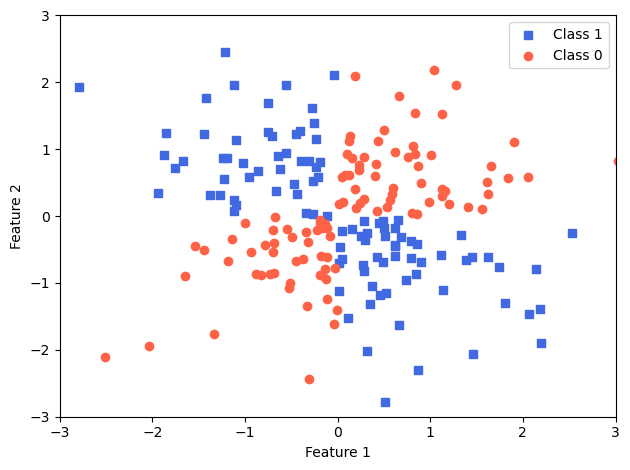

In [8]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='royalblue',
            marker='s',
            label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0],
            X_xor[y_xor == 0, 1],
            c='tomato',
            marker='o',
            label='Class 0')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('figures/03_12.png', dpi=300)
plt.show()

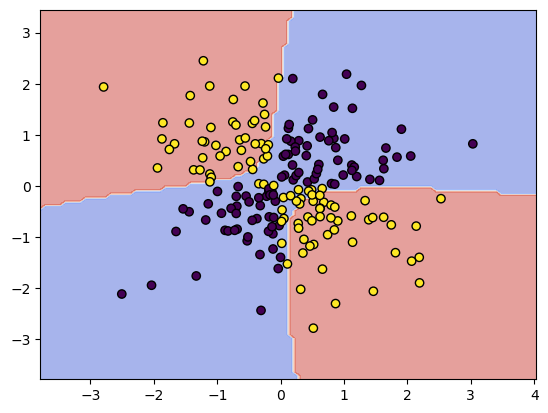

In [15]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)

disp = DecisionBoundaryDisplay.from_estimator( # life changes, we used to write display function ourselves.
    svm,                    # model
    X_xor,                  # data
    response_method="predict",  # prediction
    cmap='coolwarm',        # color
    alpha=0.5               # transparency
)
disp.ax_.scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor, edgecolor='k')

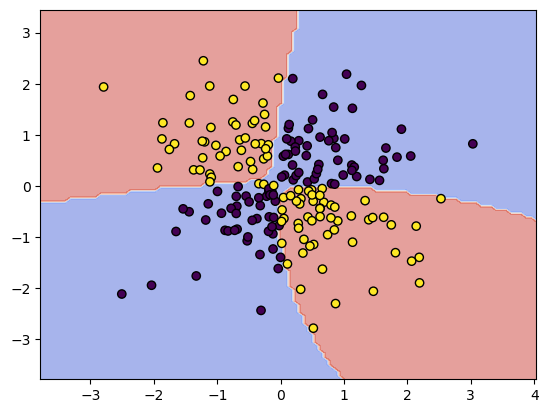

In [16]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=1000.0)
svm.fit(X_xor, y_xor)

disp = DecisionBoundaryDisplay.from_estimator(
    svm,                    # model
    X_xor,                  # data）
    response_method="predict",  # prediction
    cmap='coolwarm',        # color
    alpha=0.5               # transparency
)
disp.ax_.scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor, edgecolor='k')

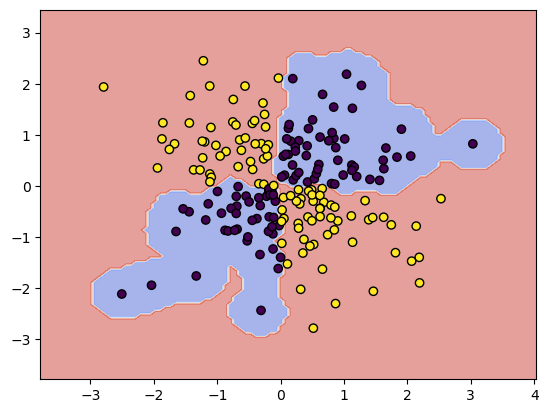

In [18]:
svm = SVC(kernel='rbf', random_state=1, gamma=10, C=10.0)
svm.fit(X_xor, y_xor)

disp = DecisionBoundaryDisplay.from_estimator(
    svm,                    # model
    X_xor,                  # data）
    response_method="predict",  # prediction
    cmap='coolwarm',        # color
    alpha=0.5               # transparency
)
disp.ax_.scatter(X_xor[:, 0], X_xor[:, 1], c=y_xor, edgecolor='k')

## CV and normalisation

- SVM needs normlisation!!
- A simple rule of thumb, just do the normlisation first. It won't hurt.

In [32]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf'))
])

# define C and gamma range
param_grid = {
    'svc__C': np.logspace(-2, 5, 10),       # C: 0.01, 0.1, 1, 10, 100
    'svc__gamma': np.logspace(-3, 1, 5)    # gamma: 0.001, 0.01, 0.1, 1, 10
}

# GridSearchCV
grid = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy')

# fit
grid.fit(X_xor, y_xor)

# print
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

Best parameters: {'svc__C': np.float64(2782.559402207126), 'svc__gamma': np.float64(0.1)}
Best cross-validation accuracy: 0.97


In [34]:
df = pd.DataFrame(grid.cv_results_)

In [23]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002025,0.000608,0.000860,0.000146,0.01,0.001,"{'svc__C': 0.01, 'svc__gamma': 0.001}",0.25,0.60,0.65,0.65,0.70,0.55,0.60,0.40,0.70,0.60,0.570,0.134536,19
1,0.001324,0.000073,0.000605,0.000068,0.01,0.010,"{'svc__C': 0.01, 'svc__gamma': 0.01}",0.30,0.50,0.65,0.65,0.55,0.65,0.45,0.55,0.40,0.60,0.530,0.112250,23
2,0.001203,0.000120,0.000534,0.000058,0.01,0.100,"{'svc__C': 0.01, 'svc__gamma': 0.1}",0.70,0.65,0.50,0.70,0.60,0.85,0.60,0.60,0.60,0.70,0.650,0.089443,16
3,0.001169,0.000079,0.000532,0.000068,0.01,1.000,"{'svc__C': 0.01, 'svc__gamma': 1.0}",1.00,0.75,0.90,0.85,0.85,1.00,1.00,0.90,0.60,0.95,0.880,0.120830,10
4,0.001141,0.000050,0.000528,0.000068,0.01,10.000,"{'svc__C': 0.01, 'svc__gamma': 10.0}",0.80,0.90,0.90,0.85,0.85,0.90,0.95,0.95,0.85,0.80,0.875,0.051235,11
5,0.001185,0.000090,0.000509,0.000033,0.10,0.001,"{'svc__C': 0.1, 'svc__gamma': 0.001}",0.25,0.60,0.65,0.65,0.70,0.55,0.60,0.40,0.70,0.60,0.570,0.134536,19
6,0.001131,0.000048,0.000496,0.000021,0.10,0.010,"{'svc__C': 0.1, 'svc__gamma': 0.01}",0.30,0.50,0.65,0.65,0.55,0.65,0.45,0.55,0.40,0.60,0.530,0.112250,23
7,0.001144,0.000051,0.000508,0.000030,0.10,0.100,"{'svc__C': 0.1, 'svc__gamma': 0.1}",0.70,0.65,0.50,0.70,0.60,0.85,0.60,0.60,0.60,0.70,0.650,0.089443,16
8,0.001062,0.000045,0.000476,0.000026,0.10,1.000,"{'svc__C': 0.1, 'svc__gamma': 1.0}",1.00,0.80,0.85,0.90,0.85,1.00,0.95,0.90,0.65,0.95,0.885,0.100125,9
9,0.001157,0.000070,0.000510,0.000037,0.10,10.000,"{'svc__C': 0.1, 'svc__gamma': 10.0}",0.80,0.90,0.90,0.85,0.85,0.90,0.95,0.95,0.85,0.80,0.875,0.051235,11


In [33]:
grid.best_params_

{'svc__C': np.float64(2782.559402207126), 'svc__gamma': np.float64(0.1)}

In [36]:
pivot = df.pivot(index='param_svc__gamma', columns='param_svc__C', values='mean_test_score')

# create plotly figure
fig = go.Figure(
    data=go.Contour(
        z=pivot.values,
        x=np.log10(pivot.columns.values),  # log10(C)
        y=np.log10(pivot.index.values),    # log10(gamma)
        colorscale='Viridis',
        contours_coloring='heatmap',
        colorbar=dict(title='Mean Test Score')
    )
)

fig.add_trace(go.Scatter(
    x=[np.log10(grid.best_params_['svc__C'])],
    y=[np.log10(grid.best_params_['svc__gamma'])],
    mode='markers+text',
    marker=dict(color='red', size=12, symbol='x'),
    text=[f"{grid.best_score_:.3f}"],
    textposition='top center',
    name='Best Parameters'
))

# set axis
fig.update_layout(
    title='SVC Grid Search Mean Score Contour',
    xaxis_title='log10(C)',
    yaxis_title='log10(gamma)',
    xaxis=dict(
        tickmode='array',
        tickvals=np.log10(pivot.columns.values),
        ticktext=[f"{v:.2g}" for v in pivot.columns.values]
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=np.log10(pivot.index.values),
        ticktext=[f"{v:.2g}" for v in pivot.index.values]
    ),
    height=600,
    width=700
)

fig.show()